In [22]:
!pip install segmentation_models_pytorch --quiet

In [23]:
import os
import cv2
import time
import random
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn


import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Data

### Load Data

In [24]:
root = '/kaggle/input/'

In [26]:
def get_files(path):
    
    '''
    A function to get all filenames from a requested path
    '''
    
    files_list = []
    
    for root,dirs,files in os.walk(path):
        
        for file in files:
            if file[-3:] == 'jpg':
                files_list.append(file)
    
    return files_list

In [28]:
# Get all images filenames
trainA_files = get_files(f"{root}/horse2zebra-dataset/trainA")
trainB_files = get_files(f"{root}/horse2zebra-dataset/trainB")
trainA_seg_files = get_files(f"{root}/horse2zebra-dataset-seg/trainA_seg")
trainB_seg_files = get_files(f"{root}/horse2zebra-dataset-seg/trainB_seg")
testA_files = get_files(f"{root}/horse2zebra-dataset/testA")
testB_files = get_files(f"{root}/horse2zebra-dataset/testB")

In [29]:
# A = Horses
# B = Zebras

print(f"Train A: \t{len(trainA_files)}")
print(f"Train B: \t{len(trainB_files)}")
print(f"Train A Seg.: \t{len(trainA_seg_files)}")
print(f"Train B Seg.: \t{len(trainB_seg_files)}")
print(f"Test A: \t{len(testA_files)}")
print(f"Test B: \t{len(testB_files)}")

Train A: 	1067
Train B: 	1334
Train A Seg.: 	1067
Train B Seg.: 	1327
Test A: 	120
Test B: 	140


### DataLoaders

In [30]:
class Horses2zebraDataset(Dataset):
    
    def __init__(self, files_list, root='/kaggle/input', folder='trainA', test=False):
        
        self.files_list = files_list
        self.folder = folder
        self.test = test
        
        self.root = root
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.403], std=[0.229,0.224,0.225])
        ])
        self.seg_transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, idx, show_filename=False):
        
        filename = self.files_list[idx]
        
        if show_filename:
            print(filename)
        
        no_seg_files = ['n02391049_2999.jpg', 'n02391049_4805.jpg', 'n02391049_9016.jpg', 'n02391049_5791.jpg', 'n02391049_7.jpg', 'n02391049_627.jpg', 'n02391049_7911.jpg']
        if filename in no_seg_files:
            filename = self.files_list[idx+1]
        
        
        img_path = f"{self.root}/horse2zebra-dataset/{self.folder}/{filename}"
        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)
        
        if not self.test:
            seg_path = f"{self.root}/horse2zebra-dataset-seg/{self.folder}_seg/{filename}"
            seg = Image.open(seg_path).convert("L")
            seg = self.seg_transform(seg)
        
            return img,seg
        
        return img

In [31]:
trainA_dataset = Horses2zebraDataset(trainA_files, root='/kaggle/input', folder='trainA')
trainB_dataset = Horses2zebraDataset(trainB_files, root='/kaggle/input', folder='trainB')
testA_dataset = Horses2zebraDataset(testA_files, root='/kaggle/input', folder='testA', test=True)
testB_dataset = Horses2zebraDataset(testB_files, root='/kaggle/input', folder='testB', test=True)

batch_size = 1
trainA_dataloader = DataLoader(dataset=trainA_dataset, batch_size=batch_size, shuffle=True)
trainB_dataloader = DataLoader(dataset=trainB_dataset, batch_size=batch_size, shuffle=True)
testA_dataloader = DataLoader(dataset=testA_dataset, batch_size=batch_size, shuffle=False)
testB_dataloader = DataLoader(dataset=testB_dataset, batch_size=batch_size, shuffle=False)

In [32]:
def unnormalize(img, mean=[0.485,0.456,0.403],std=[0.229,0.224,0.225]):
    
    '''
    Unnormalize the image for visualization purposes
    '''
    
    if img.shape[0] == 3:
        img = img.permute(1,2,0)
    
    img = img.numpy()
    
    return img*std + mean

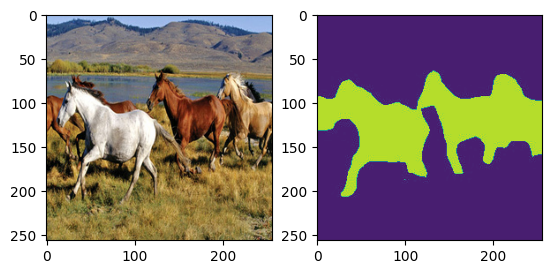

In [8]:
for i,s in trainA_dataloader:
    img,seg = i,s
    break
    
plt.subplot(1,2,1), plt.imshow(unnormalize(img[0].permute(1,2,0))),
plt.subplot(1,2,2), plt.imshow(seg[0][0])
plt.show()

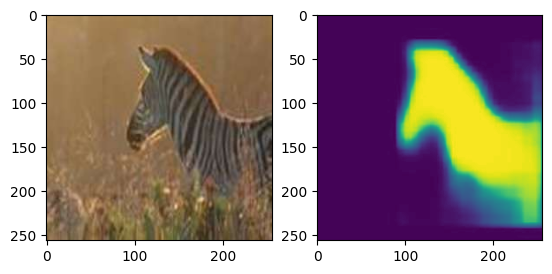

In [11]:
for i,s in trainB_dataloader:
    img,seg = i,s
    break
    
plt.subplot(1,2,1), plt.imshow(unnormalize(img[0].permute(1,2,0))),
plt.subplot(1,2,2), plt.imshow(seg[0][0])
plt.show()

## Memory Handling

In [33]:
import gc
import torch
import tabulate

class MemoryHandling():
    
    '''
    Memory handling class that we created to monitor memory leaks
    '''
    
    def __init__(self, device='cuda'):
        
        self.device = device
        self.var_list = []
        self.var_list_delete = []
    
    def get_memory_status(self):
        
        torch.cuda.synchronize(self.device)
        print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} / {torch.cuda.get_device_properties(self.device).total_memory / 1024**2} MB")
    
    def clear_variable(self, var_name):
       
        print(global_vars)
        if var_name in global_vars:
            del global_vars[var_name]
            gc.collect()
            torch.cuda.empty_cache()
        
        else:
            print(f"Variable '{var_name}' not found.")
    
    def clear_all(self):
        
        global_vars = globals()
        
    def print_gpu_tensors_info(self):

        self.var_list = []
        self.var_list.append(["Variable","Shape","Size [bytes]","Device"])
        
        # Iterate through all objects in the current global scope
        for var_name, obj in globals().items():
            try:
                if obj.is_cuda:
                    tensor_size = obj.element_size() * obj.nelement()
                    self.var_list.append([var_name, obj.size(), tensor_size, obj.device])

            except:
                pass

        print(tabulate.tabulate(self.var_list, headers='firstrow'))
        print()
        self.get_memory_status()

In [34]:
memhnd = MemoryHandling()
memhnd.print_gpu_tensors_info()

Variable    Shape                              Size [bytes]  Device
----------  -------------------------------  --------------  --------
track_imgA  torch.Size([1, 1, 3, 256, 256])          786432  cuda:0
track_imgB  torch.Size([1, 1, 3, 256, 256])          786432  cuda:0

Memory Allocated: 1.50 / 16269.25 MB


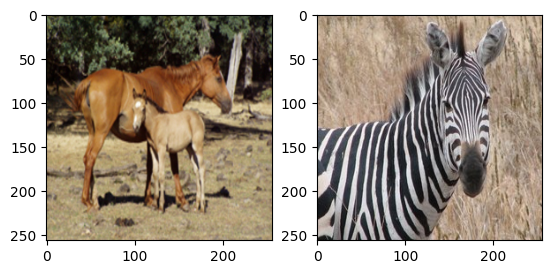

In [35]:
# Track images to monitor model performance during training

track_imgA = testA_dataset.__getitem__(36, show_filename=False)
track_imgB = testB_dataset.__getitem__(6, show_filename=False)

plt.subplot(1,2,1), plt.imshow(unnormalize(track_imgA))
plt.subplot(1,2,2), plt.imshow(unnormalize(track_imgB))
plt.show()

In [36]:
track_imgA = track_imgA.unsqueeze(0).to('cuda')
track_imgB = track_imgB.unsqueeze(0).to('cuda')

## Architecture

$$\large \text{Conv. Out Shape:} \hspace{4mm} \frac{H - F + 2P}{S} + 1 $$

### Attention Module

In [37]:
class AttentionModule(nn.Module):
    
    def __init__(self, in_channels, mid_channels, out_channels):
        super(AttentionModule, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        
        self.instnorm1 = nn.InstanceNorm2d(num_features = mid_channels)
        self.instnorm2 = nn.InstanceNorm2d(num_features = out_channels)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x, seg_map, verbose=False):
        
        if verbose: print("\tAttention")
        if verbose: print(f"\t\tinput.shape: {x.shape}")
        
        original_x = x
        x = torch.cat([x, seg_map], dim=1)
        if verbose: print(f"\t\tconcat.shape: {x.shape}")
        
        x = self.relu(self.instnorm1(self.conv1(x)))
        if verbose: print(f"\t\tconv1.shape: {x.shape}")
        attention_map = self.sigmoid(self.instnorm2(self.conv2(x)))
        if verbose: print(f"\t\tattention map.shape: {attention_map.shape}")
        
        return original_x*attention_map + original_x, attention_map

### Discriminator

In [39]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()
        self.identity = nn.Identity()
        
        # Downsampling
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.instnorm1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.instnorm2 = nn.InstanceNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.instnorm3 = nn.InstanceNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.instnorm4 = nn.InstanceNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.instnorm5 = nn.InstanceNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 1, 3, 1, 1)
        

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):
        
        print("Initializing Weights")
        # Iterate through all modules and apply initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)
    
    
    def forward(self, x, verbose=False):
        
        if verbose: print(f"input shape: {x.shape}")
        if verbose: print(f"Seg_map shape: {seg_map.shape}")
        
        if verbose: print("Downsampling")
        # Downsampling
        x = self.leaky_relu(self.instnorm1(self.conv1(x)))
        if verbose: print(f"\tout1 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm2(self.conv2(x)))
        if verbose: print(f"\tout2 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm3(self.conv3(x)))
        if verbose: print(f"\tout3 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm4(self.conv4(x)))
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm5(self.conv5(x)))
        if verbose: print(f"\tout5 shape: {x.shape}")
        
        x = self.conv6(x)
        if verbose: print(f"\tout6 shape: {x.shape}")
        
        # Using Sigmoid if using BCE loss
#         x = self.sigmoid(x)
        
        # Using Identity if using L1 loss
        x = self.identity(x)
        
        
        return x

### Generator

In [40]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.dim_reduction = nn.Conv2d(512,256,1,1,0)
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, 7, 1, 3)
        self.instnorm1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 2, 1)
        self.instnorm2 = nn.InstanceNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 2, 1)
        self.instnorm3 = nn.InstanceNorm2d(256)
        
        # Residual Blocks
        self.res_block = nn.Sequential(nn.Conv2d(256,256,3,1,1),
                                       nn.InstanceNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256,256,3,1,1),
                                       nn.InstanceNorm2d(256))
        
        # Residual Blocks Attention
        self.res_block_attn = AttentionModule(256+1,128, 1)
        
        # Decoder - Upsample + Convolution
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)               # 64x64  ->  128x128
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        # Post Residual Blocks Attention
        self.post_res_blocks_attn = AttentionModule(64+1, 32, 1)
        
        
        # Initialize weights
        self._initialize_weights()


#         '''
        # Decoder - Transposed Convolution
#         self.convtrans4 = nn.ConvTranspose2d(256,128,3,2,0)
#         self.instnorm4 = nn.InstanceNorm2d(128)
#         self.convtrans5 = nn.ConvTranspose2d(128,64,3,2,0)
#         self.instnorm5 = nn.InstanceNorm2d(64)
#         self.conv6 = nn.Conv2d(64,3,4,1,0)
#         '''



    def _initialize_weights(self):
    
        print("Initializing Weights")
        # Iterate through all modules and apply initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)
        

        
    
    def forward(self, x, seg_map, n_res=9, verbose=False):
        
        if verbose: print("Generator")
        if verbose: print(f"input img shape: {x.shape}\tseg map shape: {seg_map.shape}")        # x shape: [N,3,256,256] , seg_map shape: [N,1,256,256]
        
        if verbose: print("Encoder")
        # Encoder
        x = self.relu(self.instnorm1(self.conv1(x)))        # [N,64,256,256]
        if verbose: print(f"\tout1 shape: {x.shape}")
        x = self.relu(self.instnorm2(self.conv2(x)))        # [N,128,128,128]
        if verbose: print(f"\tout2 shape: {x.shape}")
        x = self.relu(self.instnorm3(self.conv3(x)))        # [N,256,64,64]
        if verbose: print(f"\tout3 shape: {x.shape}")
        
        
        if verbose: print("Residual Blocks")
        # Residual Block
        for i in range(n_res):
            xx = self.res_block(x)                                     # [N,256,64,64]
            x = torch.cat([x,xx], dim=1)                               # [N,512,64,64]
            if verbose: print(f"\tconcat. shape: {x.shape}")
            x = self.dim_reduction(x)                                  # [N,256,64,64]
            if verbose: print(f"\tdim reduction shape: {x.shape}")
            
            ## Attention
            resized_seg = F.interpolate(seg_map, size=x.shape[2:], mode='bilinear', align_corners=True)      # resized_seg_map shape: [N,1,64,64]
            x, res_attention_map = self.res_block_attn(x, resized_seg)                                       # x shape:  [N,256,64,64] , res_seg_map shape: [N,1,64,64]
            if verbose: print(f"\tRes-Block Attention: {x.shape}")
        
        
        if verbose: print("Decoder")
        
        
        x = self.relu(self.conv4(self.upsample(x)))                 # [N,128,128,128]
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.relu(self.conv5(self.upsample(x)))                 # [N,64,256,256]
        if verbose: print(f"\tout5 shape: {x.shape}")
            
        ## Attention
        resized_seg = F.interpolate(seg_map, size=x.shape[2:], mode='bilinear', align_corners=True)       # resized_seg_map shape: [N,1,256,256]
        if verbose: print(f"\t\tdec_resized_seg.shape: {resized_seg.shape}")
        x, dec_attention_map = self.post_res_blocks_attn(x, resized_seg)                                  # x shape:  [N,64,256,256] , res_seg_map shape: [N,1,256,256]
        if verbose: print(f"\tpost-attention shape: {x.shape}")
            
        x = self.tanh(self.conv6(x))                               # [N,3,256,256]
        if verbose: print(f"\tout6 shape: {x.shape}")
        
        
        # Upsample the Residual-attention to match the decoder attention map
        res_attention_map = F.interpolate(res_attention_map, size=dec_attention_map.shape[2:], mode='bilinear', align_corners=True)
    
        '''
        # Decoder - Transposed Convolution
        x = self.relu(self.instnorm4(self.convtrans4(x)))
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.relu(self.instnorm5(self.convtrans5(x)))
        if verbose: print(f"\tout5 shape: {x.shape}")
        x = self.tanh(self.conv6(x))
        if verbose: print(f"\tout6 shape: {x.shape}")
        '''
        
        return x, res_attention_map, dec_attention_map

### Cycle GAN with Segmentation-guided Attention

In [41]:
class CycleGAN():
    
    def __init__(self, device='cuda'):
        
        self.device = device
        self.epoch = 0
        
        ## Generators and Discriminators
        self.G_AB = Generator().to(self.device)
        self.G_BA = Generator().to(self.device)
        self.D_A = Discriminator().to(self.device)
        self.D_B = Discriminator().to(self.device)
        
        
        ## Optimizers
        self.opt_G = optim.Adam(itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
        self.opt_D_A = optim.Adam(self.D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.opt_D_B = optim.Adam(self.D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
        
        
        ## Loss Functions
        self.criterion_gan = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()
        self.attention_loss = nn.MSELoss()           # Compare the attention maps
        self.seg_attention_loss = nn.L1Loss()        # Compare segmentation with (weighted) attention maps
        
        ## Image Pools
        self.pool_A, self.pool_B = [],[]
        
        ## Loss Accumulators
        self.loss_G_A_all, self.loss_G_B_all = [], []
        self.loss_identity_A_all, self.loss_identity_B_all = [],[]
        self.loss_cycle_A_all, self.loss_cycle_B_all = [],[]
        self.loss_G_all = []
        self.D_A_fake_loss_all, self.D_B_fake_loss_all = [],[]
        self.D_A_loss_all, self.D_B_loss_all = [],[]
        self.D_A_real_loss_all,self.D_B_real_loss_all = [],[]
        self.attention_loss_all_A, self.attention_loss_all_B = [],[]
        self.seg_attention_loss_all_A, self.seg_attention_loss_all_B = [],[]
        
        ## Training Tracking
        self.track_imgsA,self.track_imgsB = [],[]
        self.track_res_attn_A,self.track_res_attn_B = [],[]
        self.track_dec_attn_A,self.track_dec_attn_B = [],[]

    
    def train_generator(self, real_A, seg_A, real_B, seg_B):
        
        # Adversarial Loss for generator A -> B and B -> A
        fake_B, res_attention_map_A, dec_attention_map_A = self.G_AB(real_A, seg_A)
        fake_A, res_attention_map_B, dec_attention_map_B = self.G_BA(real_B, seg_B)
        
        # Advarserial Loss
        loss_G_A = self.criterion_gan(self.D_A(fake_A), torch.ones_like(self.D_A(fake_A))*0.9)
        loss_G_B = self.criterion_gan(self.D_B(fake_B), torch.ones_like(self.D_B(fake_B))*0.9)

        # Identity Loss
        loss_identity_A = self.criterion_identity(self.G_BA(real_A, seg_A)[0], real_A)
        loss_identity_B = self.criterion_identity(self.G_AB(real_B, seg_B)[0], real_B)

        # Cycle Consistency Loss
        recov_A = self.G_BA(fake_B, seg_A)[0]
        recov_B = self.G_AB(fake_A, seg_B)[0]
        loss_cycle_A = self.criterion_cycle(recov_A, real_A)
        loss_cycle_B = self.criterion_cycle(recov_B, real_B)
        
        # Attention Loss
        attention_maps_loss_A = self.attention_loss(res_attention_map_A, dec_attention_map_A)
        attention_maps_loss_B = self.attention_loss(res_attention_map_B, dec_attention_map_B)
        
        total_attention_map_A = (0.8*res_attention_map_A) + (0.2*dec_attention_map_A)
        total_attention_map_B = (0.8*res_attention_map_B) + (0.2*dec_attention_map_B)
        
        seg_attention_loss_A = self.seg_attention_loss(seg_A, total_attention_map_A)
        seg_attention_loss_B = self.seg_attention_loss(seg_B, total_attention_map_B)

        
        # Combined Generator Loss
#       Total  =    Adv. loss A&B                       Attention Maps loss                                  Segmentation-attention loss     
        loss_G = loss_G_A + loss_G_B + 0.5*(attention_maps_loss_A+attention_maps_loss_B) + 0.5*(seg_attention_loss_A+seg_attention_loss_B) \
                 + 2.5 * (loss_identity_A + loss_identity_B) + 5.0 * (loss_cycle_A + loss_cycle_B)
#                                Identity loss                               Cycle Loss
        
        self.opt_G.zero_grad()
        loss_G.backward()
        self.opt_G.step()
        
        # Update accumulators
        
        self.loss_G_A_all.append(loss_G_A.item())
        self.loss_G_B_all.append(loss_G_B.item())
        self.loss_identity_A_all.append(loss_identity_A.item())
        self.loss_identity_B_all.append(loss_identity_B.item())
        self.loss_cycle_A_all.append(loss_cycle_A.item())
        self.loss_cycle_B_all.append(loss_cycle_B.item())
        self.loss_G_all.append(loss_G.item())
        self.attention_loss_all_A.append(attention_maps_loss_A.item())
        self.attention_loss_all_B.append(attention_maps_loss_B.item())
        self.seg_attention_loss_all_A.append(seg_attention_loss_A.item())
        self.seg_attention_loss_all_B.append(seg_attention_loss_B.item())
        
        return loss_G.item()
    
    
    
    
    def train_discriminator(self, real_A, real_B, fake_A, fake_B):
    
        # Discriminator decision
        fake_pred_A = self.D_A(fake_A)
        fake_pred_B = self.D_B(fake_B)
        
        real_pred_A = self.D_A(real_A)
        real_pred_B = self.D_B(real_B)
        
        
        ## Discriminator A train
        fake_loss_A = self.criterion_gan(fake_pred_A, torch.zeros_like(fake_pred_A)+0.1)
        real_loss_A = self.criterion_gan(real_pred_A, torch.ones_like(real_pred_A)*0.9)
        
        D_A_loss = (fake_loss_A + real_loss_A) * 0.5
        
        self.opt_D_A.zero_grad()
        D_A_loss.backward()
        self.opt_D_A.step()
        
        
        ## Discriminator B train
        fake_loss_B = self.criterion_gan(fake_pred_B, torch.zeros_like(fake_pred_B)+0.1)
        real_loss_B = self.criterion_gan(real_pred_B, torch.ones_like(real_pred_B)*0.9)

        D_B_loss = (fake_loss_B + real_loss_B) * 0.5
        
        self.opt_D_B.zero_grad()
        D_B_loss.backward()
        self.opt_D_B.step()

        
        self.D_A_fake_loss_all.append(fake_loss_A.item())
        self.D_B_fake_loss_all.append(fake_loss_B.item())
        self.D_A_real_loss_all.append(real_loss_A.item())
        self.D_B_real_loss_all.append(real_loss_B.item())
        self.D_A_loss_all.append(D_A_loss.item())
        self.D_B_loss_all.append(D_B_loss.item())
       
        return D_A_loss.item(), D_B_loss.item()
        
        
    def images_pool(self, pool, fake_imgs, max_imgs=50):
    
        '''
        Method:
        - If the pool is not full, the new image is added to the pool.
        - If the pool is full, a decision is made whether to keep the new image:
          -If the image is kept, a random image in the pool is replaced by the new image (the replaced image will still be used in the current list but is removed from the pool).
          -If the image is not kept, the new image will be used in the current list but not added to the pool.
        '''
        
        current_batch = []
        
        for img in fake_imgs:
            
            # if pool is not full
            if len(pool) < max_imgs:
                pool.append(img)
                current_batch.append(img)
            
            # if the pool is not full, 50% chance to keep the image (>0.5) and randomly replace an existing image from the pool
            elif random.random() > 0.5:
                idx = random.randint(0, max_imgs-1)
                current_batch.append(pool[idx])
                pool[idx] = img
            
            # otherwise, append the image to the current batch, but not to the pool
            else:
                current_batch.append(img)
            
        return torch.stack(current_batch)  
    
    
    
    
    def save_checkpoints(self, G_filename=None, D_filename=None):

        ## Save Generators Checkpoints
        generators_checkpoint = {
        'epoch': self.epoch,
        'G_AB_state_dict': self.G_AB.state_dict(),
        'G_BA_state_dict': self.G_BA.state_dict(),
        'opt_G': self.opt_G.state_dict(),
        'loss_G_A_all': self.loss_G_A_all,
        'loss_G_B_all': self.loss_G_B_all,
        'loss_identity_A_all': self.loss_identity_A_all,
        'loss_identity_B_all': self.loss_identity_B_all,
        'loss_cycle_A_all': self.loss_cycle_A_all,
        'loss_cycle_B_all': self.loss_cycle_B_all,
        'loss_G_all' : self.loss_G_all,
        'attention_loss_all_A' : self.attention_loss_all_A,
        'attention_loss_all_B' : self.attention_loss_all_B,
        'seg_attention_loss_all_A' : self.seg_attention_loss_all_A,
        'seg_attention_loss_all_B' : self.seg_attention_loss_all_B
        }
        
        if G_filename:
            torch.save(generators_checkpoint, f'{G_filename}.pth')
        else:
            torch.save(generators_checkpoint, 'CycleGAN_Generators_checkpoint.pth')


        discriminators_checkpoint = {
        'epoch': self.epoch,
        'D_A_state_dict': self.D_A.state_dict(),
        'D_B_state_dict': self.D_B.state_dict(),
        'opt_D_A': self.opt_D_A.state_dict(),
        'opt_D_B': self.opt_D_B.state_dict(),

        'D_A_fake_loss_all': self.D_A_fake_loss_all,
        'D_B_fake_loss_all': self.D_B_fake_loss_all,
        'D_A_loss_all': self.D_A_loss_all,
        'D_B_loss_all': self.D_B_loss_all,
        'D_A_real_loss_all': self.D_A_real_loss_all,
        'D_B_real_loss_all': self.D_B_real_loss_all
        }
        
        if D_filename:
            torch.save(discriminators_checkpoint, f'{D_filename}.pth')
        else:
            torch.save(discriminators_checkpoint, 'CycleGAN_Discriminators_checkpoint.pth')
    
    
    def load_checkpoints(self, generators_checkpoint_path, discriminators_checkpoint_path):

        # Load the generators' checkpoint
        if generators_checkpoint_path:
            generators_checkpoint = torch.load(generators_checkpoint_path)

            # Restore the state of the generators and optimizer
            self.G_AB.load_state_dict(generators_checkpoint['G_AB_state_dict'])
            self.G_BA.load_state_dict(generators_checkpoint['G_BA_state_dict'])
            self.opt_G.load_state_dict(generators_checkpoint['opt_G'])

            # Restore losses and epoch
            self.epoch = generators_checkpoint['epoch']
            self.loss_G_A_all = generators_checkpoint['loss_G_A_all']
            self.loss_G_B_all = generators_checkpoint['loss_G_B_all']
            self.loss_identity_A_all = generators_checkpoint['loss_identity_A_all']
            self.loss_identity_B_all = generators_checkpoint['loss_identity_B_all']
            self.loss_cycle_A_all = generators_checkpoint['loss_cycle_A_all']
            self.loss_cycle_B_all = generators_checkpoint['loss_cycle_B_all']
            self.loss_G_all = generators_checkpoint['loss_G_all']
            
            
            self.attention_loss_all_A = generators_checkpoint['attention_loss_all_A']
            self.attention_loss_all_B = generators_checkpoint['attention_loss_all_B']
            self.seg_attention_loss_all_A = generators_checkpoint['seg_attention_loss_all_A']
            self.seg_attention_loss_all_B = generators_checkpoint['seg_attention_loss_all_B']
            
            print("Generators Checkpoints Loaded")

        # Load the discriminators' checkpoint
        if discriminators_checkpoint_path:
            discriminators_checkpoint = torch.load(discriminators_checkpoint_path)

            # Restore the state of the discriminators and optimizers
            self.D_A.load_state_dict(discriminators_checkpoint['D_A_state_dict'])
            self.D_B.load_state_dict(discriminators_checkpoint['D_B_state_dict'])
            self.opt_D_A.load_state_dict(discriminators_checkpoint['opt_D_A'])
            self.opt_D_B.load_state_dict(discriminators_checkpoint['opt_D_B'])

            # Restore losses
            self.D_A_fake_loss_all = discriminators_checkpoint['D_A_fake_loss_all']
            self.D_B_fake_loss_all = discriminators_checkpoint['D_B_fake_loss_all']
            self.D_A_loss_all = discriminators_checkpoint['D_A_loss_all']
            self.D_B_loss_all = discriminators_checkpoint['D_B_loss_all']
            self.D_A_real_loss_all = discriminators_checkpoint['D_A_real_loss_all']
            self.D_B_real_loss_all = discriminators_checkpoint['D_B_real_loss_all']
            
            print("Discriminators Checkpoints Loaded")


        
    
    def train(self, trainA_dataloader, trainB_dataloader, max_epochs=10, max_per_epoch=1e4, track_imgA=None, track_imgB=None):
        
        self.G_AB.train()
        self.G_BA.train()
        self.D_A.train()
        self.D_B.train()
        
        max_epochs = self.epoch + max_epochs
        
        for _ in range(self.epoch, max_epochs):
            
            self.pool_A, self.pool_B = [],[]
            
            idx = 0
            
            loss_G_epoch = []
            loss_D_A_epoch = []
            loss_D_B_epoch = []
            
            
            for horses,zebras in tqdm(zip(trainA_dataloader, trainB_dataloader), total=min(len(trainA_dataloader),len(trainB_dataloader), (max_per_epoch//trainA_dataloader.batch_size))):
                
                if (idx*trainA_dataloader.batch_size) > max_per_epoch:
                    break
                
                
                real_A, seg_A = horses
                real_B, seg_B = zebras
                
                real_A, seg_A = real_A.to(self.device), seg_A.to(self.device)
                real_B, seg_B = real_B.to(self.device), seg_B.to(self.device)
                
                
                ####################
                # Train Generators #
                ####################
                
                loss_G = self.train_generator(real_A, seg_A, real_B, seg_B)
                loss_G_epoch.append(loss_G)
                
                # Train discriminators every 2 minibatches
                if not idx%2:
                    
                    ########################
                    # Train Discriminators #
                    ########################
                    
                    # Image Pooling
                    fake_A = self.G_BA(real_B, seg_B)[0].cpu().detach()
                    fake_B = self.G_AB(real_A, seg_A)[0].cpu().detach()

                    fake_A = self.images_pool(self.pool_A, fake_A)
                    fake_B = self.images_pool(self.pool_B, fake_B)

                    fake_A = fake_A.to(self.device)
                    fake_B = fake_B.to(self.device)

                    loss_D_A, loss_D_B = self.train_discriminator(real_A, real_B, fake_A, fake_B)
                    
                    loss_D_A_epoch.append(loss_D_A)
                    loss_D_B_epoch.append(loss_D_B)

                    with torch.no_grad():
                        track_imgA_pred,track_res_attn_A_pred, track_dec_attn_A_pred = self.G_AB(track_imgA, seg_A)
                    with torch.no_grad():
                        track_imgB_pred,track_res_attn_B_pred, track_dec_attn_B_pred = self.G_BA(track_imgB, seg_B)

                    self.track_imgsA.append(track_imgA_pred[0].cpu().detach().permute(1,2,0))
                    self.track_res_attn_A.append(track_res_attn_A_pred[0].cpu().detach().permute(1,2,0))
                    self.track_dec_attn_A.append(track_dec_attn_A_pred[0].cpu().detach().permute(1,2,0))
                    
                    self.track_imgsB.append(track_imgB_pred[0].cpu().detach().permute(1,2,0))
                    self.track_res_attn_B.append(track_res_attn_B_pred[0].cpu().detach().permute(1,2,0))
                    self.track_dec_attn_B.append(track_dec_attn_B_pred[0].cpu().detach().permute(1,2,0))
                    
                    
                idx += 1
                
            print(f"Epoch [{self.epoch}/{max_epochs}], D_A Loss: {np.mean(loss_D_A_epoch):.4f}, D_B Loss: {np.mean(loss_D_B_epoch):.4f}, Gen Loss: {np.mean(loss_G_epoch):.4f}")
            
            self.epoch += 1
            self.save_checkpoints()

## Training

In [42]:
cyclegan = CycleGAN()

start_t = time.time()
cyclegan.train(trainA_dataloader,trainB_dataloader, max_epochs=20, max_per_epoch=150, track_imgA=track_imgA, track_imgB=track_imgB)
print(f"Total Time: {time.time()-start_t :.2f} Seconds")

Initializing Weights
Initializing Weights
Initializing Weights
Initializing Weights


151it [01:07,  2.23it/s]                         


Epoch [0/20], D_A Loss: 0.7202, D_B Loss: 0.7460, Gen Loss: 14.1486


151it [01:06,  2.28it/s]                         


Epoch [1/20], D_A Loss: 0.2544, D_B Loss: 0.2205, Gen Loss: 10.7193


151it [01:06,  2.28it/s]                         


Epoch [2/20], D_A Loss: 0.2035, D_B Loss: 0.1834, Gen Loss: 10.3883


151it [01:05,  2.29it/s]                         


Epoch [3/20], D_A Loss: 0.1859, D_B Loss: 0.1773, Gen Loss: 9.6463


151it [01:05,  2.29it/s]                         


Epoch [4/20], D_A Loss: 0.1857, D_B Loss: 0.1587, Gen Loss: 9.5964


151it [01:05,  2.30it/s]                         


Epoch [5/20], D_A Loss: 0.1660, D_B Loss: 0.1582, Gen Loss: 9.1870


151it [01:05,  2.29it/s]                         


Epoch [6/20], D_A Loss: 0.1851, D_B Loss: 0.1535, Gen Loss: 9.1977


151it [01:05,  2.30it/s]                         


Epoch [7/20], D_A Loss: 0.1671, D_B Loss: 0.1420, Gen Loss: 9.0978


151it [01:05,  2.30it/s]                         


Epoch [8/20], D_A Loss: 0.1636, D_B Loss: 0.1241, Gen Loss: 9.1397


151it [01:05,  2.29it/s]                         


Epoch [9/20], D_A Loss: 0.1522, D_B Loss: 0.1425, Gen Loss: 9.2614


151it [01:05,  2.31it/s]                         


Epoch [10/20], D_A Loss: 0.1651, D_B Loss: 0.1176, Gen Loss: 9.1025


151it [01:05,  2.31it/s]                         


Epoch [11/20], D_A Loss: 0.1622, D_B Loss: 0.1400, Gen Loss: 9.3234


151it [01:05,  2.31it/s]                         


Epoch [12/20], D_A Loss: 0.1500, D_B Loss: 0.1404, Gen Loss: 9.1220


151it [01:05,  2.31it/s]                         


Epoch [13/20], D_A Loss: 0.1492, D_B Loss: 0.1375, Gen Loss: 8.9263


151it [01:05,  2.32it/s]                         


Epoch [14/20], D_A Loss: 0.1516, D_B Loss: 0.1224, Gen Loss: 8.8390


151it [01:05,  2.32it/s]                         


Epoch [15/20], D_A Loss: 0.1475, D_B Loss: 0.1412, Gen Loss: 8.9823


151it [01:05,  2.32it/s]                         


Epoch [16/20], D_A Loss: 0.1361, D_B Loss: 0.1493, Gen Loss: 8.5461


151it [01:05,  2.32it/s]                         


Epoch [17/20], D_A Loss: 0.1493, D_B Loss: 0.1386, Gen Loss: 8.7597


151it [01:05,  2.32it/s]                         


Epoch [18/20], D_A Loss: 0.1337, D_B Loss: 0.1491, Gen Loss: 9.0879


151it [01:05,  2.32it/s]                         


Epoch [19/20], D_A Loss: 0.1202, D_B Loss: 0.1352, Gen Loss: 9.3615
Total Time: 1323.86 Seconds


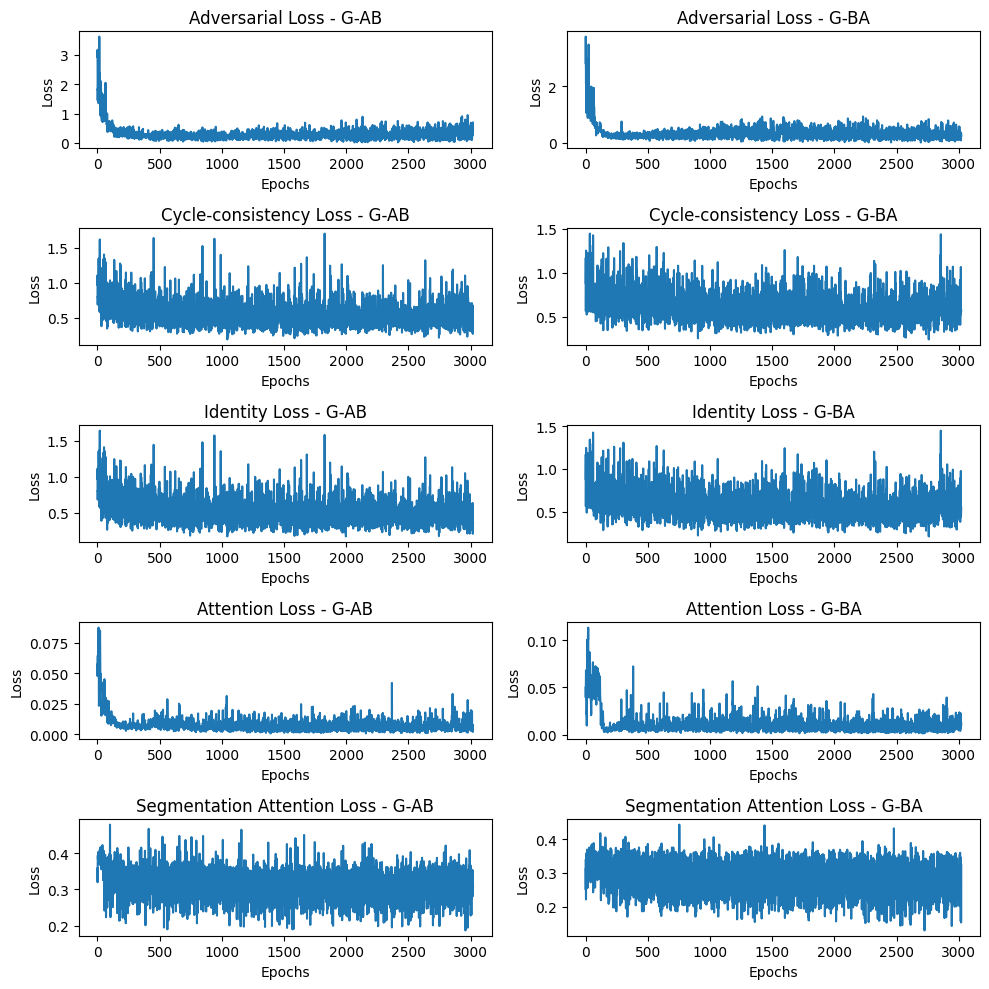

In [61]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10))


plots = [
    (cyclegan.loss_G_A_all, cyclegan.loss_G_B_all, 'Adversarial Loss - G-AB', 'Adversarial Loss - G-BA'),
    (cyclegan.loss_cycle_A_all, cyclegan.loss_cycle_B_all, 'Cycle-consistency Loss - G-AB', 'Cycle-consistency Loss - G-BA'),
    (cyclegan.loss_identity_A_all, cyclegan.loss_identity_B_all, 'Identity Loss - G-AB', 'Identity Loss - G-BA'),
    (cyclegan.attention_loss_all_A, cyclegan.attention_loss_all_B, 'Attention Loss - G-AB', 'Attention Loss - G-BA'),
    (cyclegan.seg_attention_loss_all_A, cyclegan.seg_attention_loss_all_B, 'Segmentation Attention Loss - G-AB', 'Segmentation Attention Loss - G-BA')
]

for i, (loss_a, loss_b, title_a, title_b) in enumerate(plots):
    axs[i][0].plot(loss_a)
    axs[i][1].plot(loss_b)
    
    # Set titles
    axs[i][0].set_title(title_a)
    axs[i][1].set_title(title_b)
    
    # Set x and y labels for both columns
    axs[i][0].set_xlabel('Epochs')
    axs[i][1].set_xlabel('Epochs')
    axs[i][0].set_ylabel('Loss')
    axs[i][1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

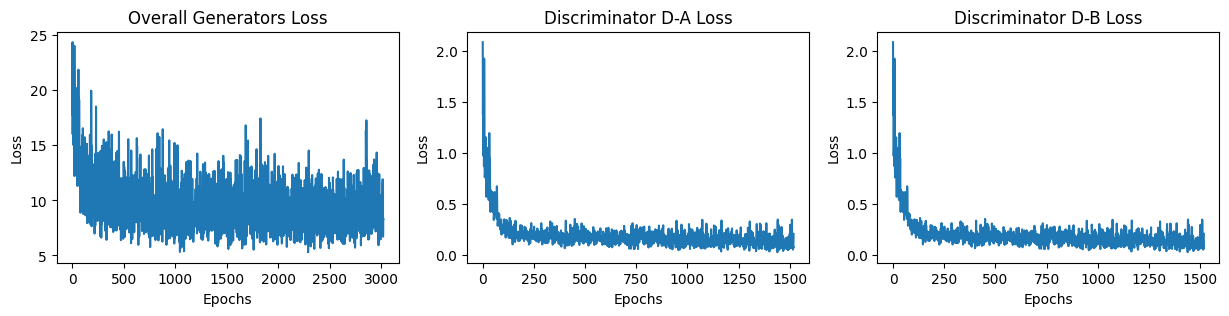

In [82]:
fig,axs = plt.subplots(1,3,figsize=(15,3))

axs[0].plot(cyclegan.loss_G_all)
axs[0].set_title('Overall Generators Loss')
axs[1].plot(cyclegan.D_A_loss_all)
axs[1].set_title('Discriminator D-A Loss')
axs[2].plot(cyclegan.D_A_loss_all)
axs[2].set_title('Discriminator D-B Loss')

for i in range(3):
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')

plt.show()

## Architecture for Inference (build-in segmentation)

#### Horse Segmentation

In [105]:
class HorseSegmentation():
    
    def __init__(self, root='/kaggle/input'):
        
        self.root = root
        
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
            
        self.preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.403], std=[0.229,0.224,0.225])
        ])
    
    def _preprocess(self, img):
        
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        img = self.preprocess(img)
        
        return img.unsqueeze(0)
    
    
    
    def apply_segmentation(self, img):
        
        img = self._preprocess(img)
        
        with torch.no_grad():
            prediction = self.model(img)['out'][0]
            
        seg_map = prediction.argmax(0)
        return seg_map

In [106]:
class ZebraSegmentation():
    
    def __init__(self, root='/kaggle/input', threshold=0.5):
        
        self.root = root
        
        self.model = maskrcnn_resnet50_fpn(pretrained=True).eval()
        self.threshold = threshold
        
        self.preprocess = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def _preprocess(self, img_path):
        
        img = Image.open(img_path).convert("RGB")
        img = self.preprocess(img)
        return img
        
    
    def plot_predictions(self, img, boxes, masks, figsize=(10,10)):
        
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format and numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8 type
        fig, ax = plt.subplots(1, figsize=figsize)
        ax.imshow(img)
        for box, mask in zip(boxes, masks):
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
            mask = mask[0] >= 0.5

            # Create a red mask for overlay
            red_mask = np.zeros_like(img)
            red_mask[mask] = [255, 0, 0]

            # Overlay the red mask on the image with some transparency
            img = cv2.addWeighted(img, 1, red_mask, 0.5, 0)

            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                ax.plot(contour[:, 0, 0], contour[:, 0, 1], color='yellow', linewidth=2)
        plt.axis('off')
    
    
    def get_prediction(self, img_path):
        
        img = self._preprocess(f"{self.root}/{img_path}")
        
        with torch.no_grad():
            prediction = self.model([img])

        pred_scores = prediction[0]['scores'].detach().numpy()
        pred_labels = prediction[0]['labels'].detach().numpy()
        pred_boxes = prediction[0]['boxes'].detach().numpy()
        pred_masks = prediction[0]['masks'].detach().numpy()

        pred_threshold = pred_scores >= self.threshold
        pred_scores = pred_scores[pred_threshold]
        pred_labels = pred_labels[pred_threshold]
        pred_boxes = pred_boxes[pred_threshold]
        pred_masks = pred_masks[pred_threshold]

        return pred_boxes, pred_labels, pred_scores, pred_masks, img    

In [107]:
class horse2zebra():
    
    def __init__(self, model=None, g_ckp=None, d_ckp=None):
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        if model is None:
            self.cyclegan = CycleGAN(self.device)
        else:
            self.cyclegan = model
            
        self._load_cyclegan(g_ckp,d_ckp)
        
        self.horse_seg = HorseSegmentation()
        
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.403], std=[0.229,0.224,0.225])
        ])
        self.seg_transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def _load_cyclegan(self, g_ckp, d_ckp):
        self.cyclegan.load_checkpoints(g_ckp, d_ckp)
    
    def _unnormalize(self, img, mean=[0.485,0.456,0.403],std=[0.229,0.224,0.225]):
    
        if isinstance(img,torch.Tensor):
            img = img.permute(1,2,0).numpy()

        return img*std + mean
    

    def forward(self, img):
        
        # Create segmentation map
        seg_map = self.horse_seg.apply_segmentation(img).float().to(self.device)
        
        img = self.img_transform(img).to(self.device)
        
        img = img.unsqueeze(0)
        seg_map = seg_map.unsqueeze(0).unsqueeze(0)
        
        out = self.cyclegan.G_AB(img,seg_map)
        out = [o.cpu().detach() for o in out]
        
        out,res_attn_map,dec_attn_map = (
            out[0].squeeze().permute(1,2,0).numpy(),
            out[1].squeeze().numpy(),
            out[2].squeeze().numpy()
        )
        seg_map = seg_map.cpu().detach().squeeze()
        out = self._unnormalize(out)
        
        return out,seg_map,res_attn_map,dec_attn_map

In [108]:
class zebra2horse():
    
    def __init__(self, model=None, g_ckp=None, d_ckp=None):
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        if model is None:
            self.cyclegan = CycleGAN(self.device)
        else:
            self.cyclegan = model
            
        self._load_cyclegan(g_ckp,d_ckp)
        
        self.horse_seg = HorseSegmentation()
        self.zebra_seg = ZebraSegmentation()
        
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.403], std=[0.229,0.224,0.225])
        ])
        self.seg_transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def _load_cyclegan(self, g_ckp, d_ckp):
        self.cyclegan.load_checkpoints(g_ckp, d_ckp)
    
    def _unnormalize(self, img, mean=[0.485,0.456,0.403],std=[0.229,0.224,0.225]):
    
        if isinstance(img,torch.Tensor):
            img = img.permute(1,2,0).numpy()

        return img*std + mean
    

    def forward(self, img_path):
        
        
        # Create segmentation map
#         seg_map = self.horse_seg.apply_segmentation(img).float().to(self.device)
        _,_,_,seg_map,_ = self.zebra_seg.get_prediction(img_path)
        seg_map = torch.from_numpy(seg_map)
        
        img = plt.imread(f"/kaggle/input/{img_path}")
        img = self.img_transform(img).to(self.device)
        
        img = img.unsqueeze(0)
        seg_map = seg_map.to(self.device)
        
        
        
        out = self.cyclegan.G_BA(img,seg_map)
        out = [o.cpu().detach() for o in out]
        
        out,res_attn_map,dec_attn_map = (
            out[0].squeeze().permute(1,2,0).numpy(),
            out[1].squeeze().numpy(),
            out[2].squeeze().numpy()
        )
        seg_map = seg_map.cpu().detach().squeeze()
        out = self._unnormalize(out)
        
        return out,seg_map,res_attn_map,dec_attn_map

In [121]:
g_ckp = '/kaggle/input/checkpoint-2/CycleGAN_Generators_checkpoint (1).pth'
d_ckp = '/kaggle/input/checkpoint-2/CycleGAN_Discriminators_checkpoint (1).pth'

z2h = zebra2horse(g_ckp=g_ckp,
                  d_ckp=d_ckp)

Initializing Weights
Initializing Weights
Initializing Weights
Initializing Weights
Generators Checkpoints Loaded
Discriminators Checkpoints Loaded


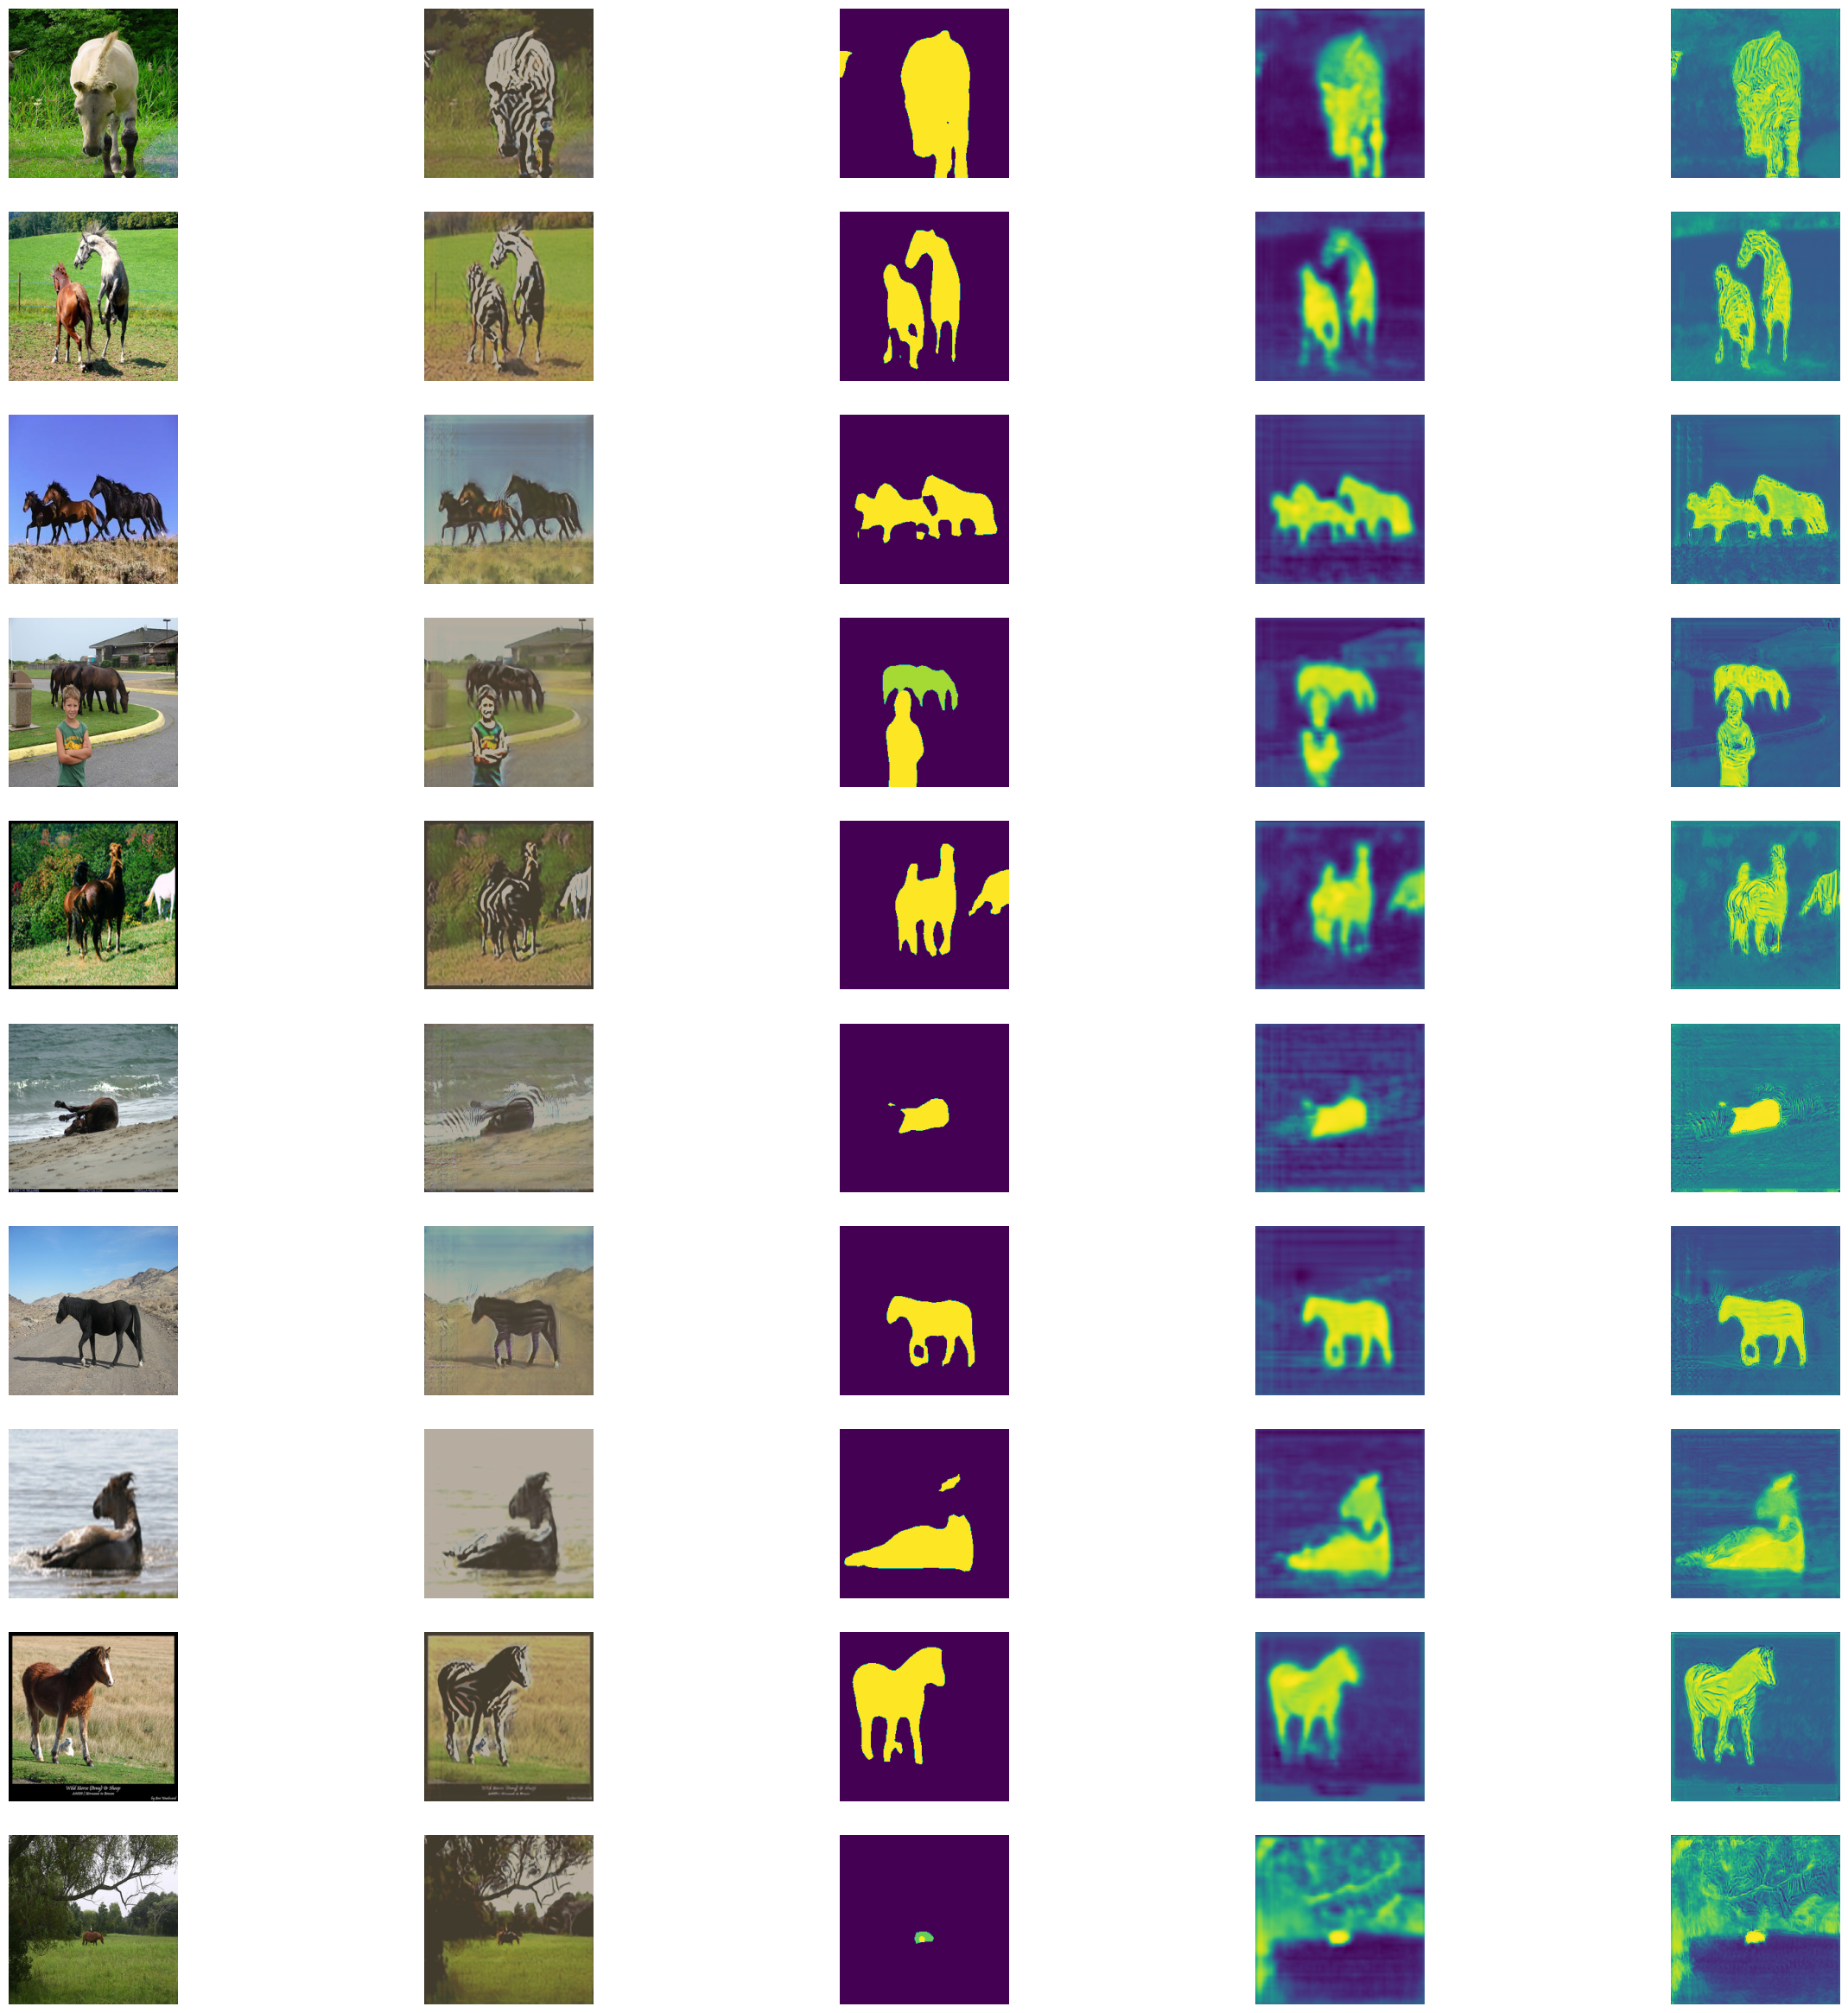

In [50]:
rows = 10
cols = 5

fig,axs = plt.subplots(rows,cols, figsize=(30,30))

for r in range(rows):
    axs[r][0].imshow(img_all[r])
    axs[r][1].imshow(out_all[r])
    axs[r][2].imshow(seg_map_all[r])
    axs[r][3].imshow(res_attn_map_all[r])
    axs[r][4].imshow(dec_attn_map_all[r])

for ax in axs.flat:
    ax.axis('off')

In [163]:
idx = 210
img_path = f"horse2zebra-dataset/trainB/{trainB_files[idx]}"
img = plt.imread(f"/kaggle/input/{img_path}")

with torch.no_grad():
    out,seg_map,res_attn_map,dec_attn_map = z2h.forward(img_path)

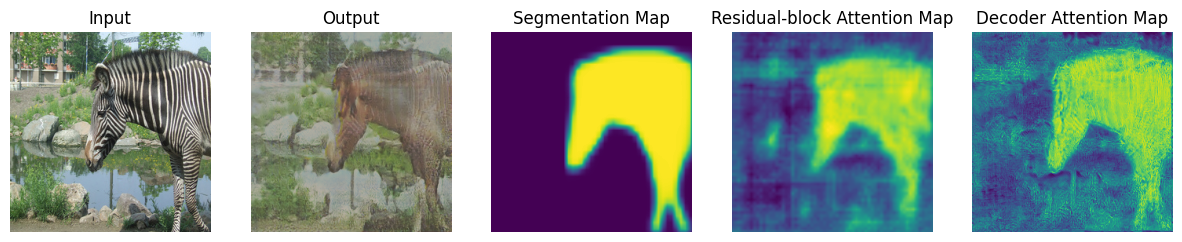

In [167]:
fig,axs = plt.subplots(1,5, figsize=(15,15))

axs[0].imshow(img)
axs[0].set_title('Input')
axs[1].imshow(out)
axs[1].set_title('Output')
axs[2].imshow(seg_map)
axs[2].set_title('Segmentation Map')
axs[3].imshow(res_attn_map)
axs[3].set_title('Residual-block Attention Map')
axs[4].imshow(dec_attn_map)
axs[4].set_title('Decoder Attention Map')

for i in range(5): axs[i].axis('off')
plt.show()

All results are on our GitHub page:
https://github.com/LiorYaacov/Horse2zebra

---

### Save Track Data

In [1]:
# Delete entire folder
!rm -rf track_info

In [2]:
!mkdir track_info
!mkdir track_info/track_imgsA
!mkdir track_info/track_imgsB
!mkdir track_info/track_res_attn_A
!mkdir track_info/track_res_attn_B
!mkdir track_info/track_dec_attn_A
!mkdir track_info/track_dec_attn_B

In [87]:
def save_track_data(root,folder,filename):
    
    if len(folder) == 1:
        folder,filename = folder[0],filename[0]
    
    print(eval(f"len(cyclegan.{folder})"))
    
    for idx,img in enumerate(tqdm(eval(f"cyclegan.{folder}"))):
        
        if 'attn' in folder:
            img = img.numpy()
        else:
            img = unnormalize(img)

        if img.shape[2] == 1:
            img = img.squeeze(2)
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        try:
            plt.imsave(f"{root}/{folder}/{filename}_{idx}.png", img)
        except:
            print(f"Error while saving image {idx}")
            print(f"{root}/{folder}/{filename}_{idx}.png")

In [88]:
import shutil

start_t = time.time()

root = '/kaggle/working/track_info'
folders = ['track_imgsA','track_imgsB','track_res_attn_A','track_res_attn_B','track_dec_attn_A','track_dec_attn_B']
filenames = ['track_imgA','track_imgB','track_res_attn_A','track_res_attn_B','track_dec_attn_A','track_dec_attn_B']


for folder,filename in zip(folders,filenames):    
    save_track_data(root,folder,filename)

print(f"Total time: {time.time()-start_t :.2f} Seconds)

3642


100%|██████████| 3642/3642 [02:13<00:00, 27.35it/s]


3642


100%|██████████| 3642/3642 [02:40<00:00, 22.66it/s]


3642


100%|██████████| 3642/3642 [02:35<00:00, 23.39it/s]


3642


100%|██████████| 3642/3642 [02:27<00:00, 24.66it/s]


3642


100%|██████████| 3642/3642 [02:35<00:00, 23.47it/s]


3642


100%|██████████| 3642/3642 [02:34<00:00, 23.63it/s]


In [89]:
shutil.make_archive('track_info', 'zip', '/kaggle/working/track_info')

'/kaggle/working/track_info.zip'

---

## Archive

### Create Segmentation Dataset for Training (One-time Run)

#### Horses

In [38]:
class HorseSegmentation():
    
    def __init__(self, root='/kaggle/input'):
        
        self.root = root
        
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
            
        self.preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.403], std=[0.229,0.224,0.225])
        ])
    
    def _preprocess(self, img_path):
        
        img = Image.open(img_path).convert("RGB")
        img = self.preprocess(img)
        
        return img.unsqueeze(0)
        
    
    def apply_segmentation(self, img_path):
        
        img = self._preprocess(f"{self.root}/{img_path}")
        
        with torch.no_grad():
            prediction = self.model(img)['out'][0]
            
        seg_map = prediction.argmax(0)
        return seg_map

##### Save Dataset

In [ ]:
!mkdir trainA_seg

In [ ]:
seg = HorseSegmentation(root='/kaggle/input/horse2zebra-dataset/trainA')
trainA_seg = {filename : seg.apply_segmentation(filename) for filename in tqdm(trainA_files)}

In [177]:
for filename,img in trainA_seg.items():
    plt.imsave(f"trainA_seg/{filename}",img)

In [182]:
import shutil
shutil.make_archive('trainA_seg', 'zip', '/kaggle/working/trainA_seg')

'/kaggle/working/trainA_seg.zip'

#### Zebras

In [27]:
class ZebraSegmentation():
    
    def __init__(self, root='/kaggle/input', threshold=0.5):
        
        self.root = root
        
        self.model = maskrcnn_resnet50_fpn(pretrained=True).eval()
        self.threshold = threshold
        
        self.preprocess = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def _preprocess(self, img_path):
        
        img = Image.open(img_path).convert("RGB")
        img = self.preprocess(img)
        return img
        
    
    def plot_predictions(self, img, boxes, masks, figsize=(10,10)):
        
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format and numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8 type
        fig, ax = plt.subplots(1, figsize=figsize)
        ax.imshow(img)
        for box, mask in zip(boxes, masks):
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
            mask = mask[0] >= 0.5

            # Create a red mask for overlay
            red_mask = np.zeros_like(img)
            red_mask[mask] = [255, 0, 0]

            # Overlay the red mask on the image with some transparency
            img = cv2.addWeighted(img, 1, red_mask, 0.5, 0)

            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                ax.plot(contour[:, 0, 0], contour[:, 0, 1], color='yellow', linewidth=2)
        plt.axis('off')
    
    
    def get_prediction(self, img_path):
        
        img = self._preprocess(f"{self.root}/{img_path}")
        
        with torch.no_grad():
            prediction = self.model([img])

        pred_scores = prediction[0]['scores'].detach().numpy()
        pred_labels = prediction[0]['labels'].detach().numpy()
        pred_boxes = prediction[0]['boxes'].detach().numpy()
        pred_masks = prediction[0]['masks'].detach().numpy()

        pred_threshold = pred_scores >= self.threshold
        pred_scores = pred_scores[pred_threshold]
        pred_labels = pred_labels[pred_threshold]
        pred_boxes = pred_boxes[pred_threshold]
        pred_masks = pred_masks[pred_threshold]

        return pred_boxes, pred_labels, pred_scores, pred_masks, img    

In [59]:
seg = ZebraSegmentation(root='/kaggle/input/horse2zebra-dataset/trainB')
img_path = 'n02391049_283.jpg'

boxes, labels, scores, masks, img = seg.get_prediction(img_path)

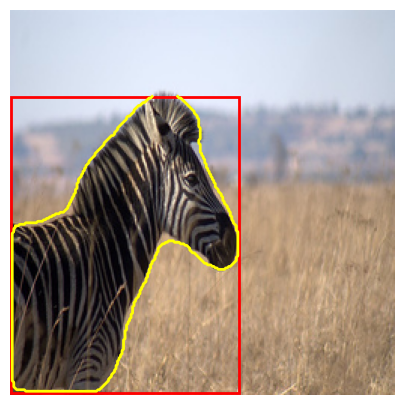

In [60]:
seg.plot_predictions(img,boxes,masks, figsize=(5,5))

(-0.5, 255.5, 255.5, -0.5)

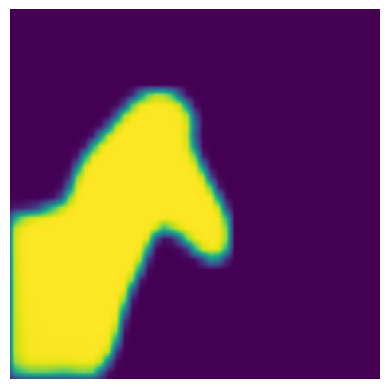

In [62]:
plt.imshow(masks[0][0])
plt.axis('off')

##### Save Dataset

In [12]:
!mkdir trainB_seg

In [13]:
seg = ZebraSegmentation(root='/kaggle/input/horse2zebra-dataset/trainB')
trainB_seg = {filename : seg.get_prediction(filename) for filename in tqdm(trainB_files)}

100%|██████████| 1334/1334 [1:17:45<00:00,  3.50s/it]


In [31]:
no_seg_maps = []
for filename,img in trainB_seg.items():
    try:
        plt.imsave(f"trainB_seg/{filename}",img[3][0][0])
    except IndexError:
        no_seg_maps.append(filename)

In [32]:
import shutil
shutil.make_archive('trainB_seg', 'zip', '/kaggle/working/trainB_seg')

'/kaggle/working/trainB_seg3.zip'

In [33]:
print(no_seg_maps)

['n02391049_2999.jpg', 'n02391049_4805.jpg', 'n02391049_9016.jpg', 'n02391049_5791.jpg', 'n02391049_7.jpg', 'n02391049_627.jpg', 'n02391049_7911.jpg']


---

### No-attention Architecture

In [172]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dim_reduction = nn.Conv2d(512,256,1,1,0)
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, 7, 1, 3)
        self.instnorm1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 2, 1)
        self.instnorm2 = nn.InstanceNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 2, 1)
        self.instnorm3 = nn.InstanceNorm2d(256)
        
        # Residual Blocks
        self.res_block = nn.Sequential(nn.Conv2d(256,256,3,1,1),
                                       nn.InstanceNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256,256,3,1,1),
                                       nn.InstanceNorm2d(256))
        
        
        # Decoder - Upsample + Convolution
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)               # 64x64  ->  128x128
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        
        # Initialize weights
        self._initialize_weights()


#         '''
        # Decoder - Transposed Convolution
#         self.convtrans4 = nn.ConvTranspose2d(256,128,3,2,0)
#         self.instnorm4 = nn.InstanceNorm2d(128)
#         self.convtrans5 = nn.ConvTranspose2d(128,64,3,2,0)
#         self.instnorm5 = nn.InstanceNorm2d(64)
#         self.conv6 = nn.Conv2d(64,3,4,1,0)
#         '''



    def _initialize_weights(self):
    
        print("Initializing Weights")
        # Iterate through all modules and apply initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)
        

        
    
    def forward(self, x, n_res=9, verbose=False):
        
        if verbose: print(f"input shape: {x.shape}")
        
        if verbose: print("Encoder")
        # Encoder
        x = self.relu(self.instnorm1(self.conv1(x)))
        if verbose: print(f"\tout1 shape: {x.shape}")
        x = self.relu(self.instnorm2(self.conv2(x)))
        if verbose: print(f"\tout2 shape: {x.shape}")
        x = self.relu(self.instnorm3(self.conv3(x)))
        if verbose: print(f"\tout3 shape: {x.shape}")
        
        
        if verbose: print("Residual Blocks")
        # Residual Block
        for i in range(n_res):
            xx = self.res_block(x)
            x = torch.cat([x,xx], dim=1)
            if verbose: print(f"\tconcat. shape: {x.shape}")
            x = self.dim_reduction(x)
            if verbose: print(f"\tdim reduction shape: {x.shape}")
        
        
        if verbose: print("Decoder")
        
        
#         '''
        x = self.relu(self.conv4(self.upsample(x)))
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.relu(self.conv5(self.upsample(x)))
        if verbose: print(f"\tout5 shape: {x.shape}")
        x = self.relu(self.conv6(x))
        if verbose: print(f"\tout6 shape: {x.shape}")
        
#         '''
    
        '''
        # Decoder - Transposed Convolution
        x = self.leaky_relu(self.instnorm4(self.convtrans4(x)))
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm5(self.convtrans5(x)))
        if verbose: print(f"\tout5 shape: {x.shape}")
        x = self.sigmoid(self.conv6(x))
        if verbose: print(f"\tout6 shape: {x.shape}")
        '''
        
        return x
    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()
        self.identity = nn.Identity()
        
        # Downsampling
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.instnorm1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.instnorm2 = nn.InstanceNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.instnorm3 = nn.InstanceNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.instnorm4 = nn.InstanceNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.instnorm5 = nn.InstanceNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 1, 3, 1, 1)
        

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):
        
        print("Initializing Weights")
        # Iterate through all modules and apply initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)
    
    
    def forward(self, x, verbose=False):
        
        if verbose: print(f"input shape: {x.shape}")
        
        if verbose: print("Downsampling")
        # Downsampling
        x = self.leaky_relu(self.instnorm1(self.conv1(x)))
        if verbose: print(f"\tout1 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm2(self.conv2(x)))
        if verbose: print(f"\tout2 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm3(self.conv3(x)))
        if verbose: print(f"\tout3 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm4(self.conv4(x)))
        if verbose: print(f"\tout4 shape: {x.shape}")
        x = self.leaky_relu(self.instnorm5(self.conv5(x)))
        if verbose: print(f"\tout5 shape: {x.shape}")

        x = self.conv6(x)
        if verbose: print(f"\tout6 shape: {x.shape}")
        
        # Using Sigmoid if using BCE loss
#         x = self.sigmoid(x)
        
        # Using Identity if using L1 loss
        x = self.identity(x)
        
        
        return x
    


class CycleGAN():
    
    def __init__(self, device='cuda'):
        
        self.device = device
        self.epoch = 0
        
        ## Generators and Discriminators
        self.G_AB = Generator().to(self.device)
        self.G_BA = Generator().to(self.device)
        self.D_A = Discriminator().to(self.device)
        self.D_B = Discriminator().to(self.device)
        
        
        ## Optimizers
        self.opt_G = optim.Adam(itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
        self.opt_D_A = optim.Adam(self.D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.opt_D_B = optim.Adam(self.D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
        
        
        ## Loss Functions
        self.criterion_gan = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()
        
        ## Image Pools
        self.pool_A, self.pool_B = [],[]
        
        ## Loss Accumulators
        self.loss_G_A_all, self.loss_G_B_all = [], []
        self.loss_identity_A_all, self.loss_identity_B_all = [],[]
        self.loss_cycle_A_all, self.loss_cycle_B_all = [],[]
        self.loss_G_all = []
        self.D_A_fake_loss_all, self.D_B_fake_loss_all = [],[]
        self.D_A_loss_all, self.D_B_loss_all = [],[]
        self.D_A_real_loss_all,self.D_B_real_loss_all = [],[]
        
        ## Training Tracking
        self.track_imgsA,self.track_imgsB = [],[]
        
    
    
    def train_generator(self, real_A, real_B):
        
        # Adversarial Loss for generator A -> B and B -> A
        fake_B = self.G_AB(real_A)
        fake_A = self.G_BA(real_B)

        loss_G_A = self.criterion_gan(self.D_A(fake_A), torch.ones_like(self.D_A(fake_A))*0.9)
        loss_G_B = self.criterion_gan(self.D_B(fake_B), torch.ones_like(self.D_B(fake_B))*0.9)

        # Identity Loss
        loss_identity_A = self.criterion_identity(self.G_BA(real_A), real_A)
        loss_identity_B = self.criterion_identity(self.G_AB(real_B), real_B)

        # Cycle Consistency Loss
        recov_A = self.G_BA(fake_B)
        recov_B = self.G_AB(fake_A)
        loss_cycle_A = self.criterion_cycle(recov_A, real_A)
        loss_cycle_B = self.criterion_cycle(recov_B, real_B)

        # Combined Generator Loss
#         loss_G = loss_G_A + loss_G_B + 5.0 * (loss_identity_A + loss_identity_B) + 10.0 * (loss_cycle_A + loss_cycle_B)
        loss_G = loss_G_A + loss_G_B + 2.5 * (loss_identity_A + loss_identity_B) + 5.0 * (loss_cycle_A + loss_cycle_B)
        
        
        self.opt_G.zero_grad()
        loss_G.backward()
        self.opt_G.step()
        
        # Update accumulators
        self.loss_G_A_all.append(loss_G_A.item())
        self.loss_G_B_all.append(loss_G_B.item())
        self.loss_identity_A_all.append(loss_identity_A.item())
        self.loss_identity_B_all.append(loss_identity_B.item())
        self.loss_cycle_A_all.append(loss_cycle_A.item())
        self.loss_cycle_B_all.append(loss_cycle_B.item())
        self.loss_G_all.append(loss_G.item())
        
        return loss_G.item()
    
    
    
    
    def train_discriminator(self, real_A, real_B, fake_A, fake_B):
    
        # Discriminator decision
        fake_pred_A = self.D_A(fake_A)
        fake_pred_B = self.D_B(fake_B)
        
        real_pred_A = self.D_A(real_A)
        real_pred_B = self.D_B(real_B)
        
        
        ## Discriminator A train
        fake_loss_A = self.criterion_gan(fake_pred_A, torch.zeros_like(fake_pred_A)+0.1)
        real_loss_A = self.criterion_gan(real_pred_A, torch.ones_like(real_pred_A)*0.9)
        
        D_A_loss = (fake_loss_A + real_loss_A) * 0.5
        
        self.opt_D_A.zero_grad()
        D_A_loss.backward()
        self.opt_D_A.step()
        
        
        ## Discriminator B train
        fake_loss_B = self.criterion_gan(fake_pred_B, torch.zeros_like(fake_pred_B)+0.1)
        real_loss_B = self.criterion_gan(real_pred_B, torch.ones_like(real_pred_B)*0.9)

        D_B_loss = (fake_loss_B + real_loss_B) * 0.5
        
        self.opt_D_B.zero_grad()
        D_B_loss.backward()
        self.opt_D_B.step()

        
        self.D_A_fake_loss_all.append(fake_loss_A.item())
        self.D_B_fake_loss_all.append(fake_loss_B.item())
        self.D_A_real_loss_all.append(real_loss_A.item())
        self.D_B_real_loss_all.append(real_loss_B.item())
        self.D_A_loss_all.append(D_A_loss.item())
        self.D_B_loss_all.append(D_B_loss.item())
       
        return D_A_loss.item(), D_B_loss.item()
        
        
    def images_pool(self, pool, fake_imgs, max_imgs=50):
    
        
        current_batch = []
        
        for img in fake_imgs:
            
            # if pool is not full
            if len(pool) < max_imgs:
                pool.append(img)
                current_batch.append(img)
            
            # if the pool is not full, 50% chance to keep the image (>0.5) and randomly replace an existing image from the pool
            elif random.random() > 0.5:
                idx = random.randint(0, max_imgs-1)
                current_batch.append(pool[idx])
                pool[idx] = img
            
            # otherwise, append the image to the current batch, but not to the pool
            else:
                current_batch.append(img)
            
        return torch.stack(current_batch)  
    
    
    def save_checkpoints(self, G_filename=None, D_filename=None):

        ## Save Generators Checkpoints
        generators_checkpoint = {
        'epoch': self.epoch,
        'G_AB_state_dict': self.G_AB.state_dict(),
        'G_BA_state_dict': self.G_BA.state_dict(),
        'opt_G': self.opt_G.state_dict(),
        'loss_G_A_all': self.loss_G_A_all,
        'loss_G_B_all': self.loss_G_B_all,
        'loss_identity_A_all': self.loss_identity_A_all,
        'loss_identity_B_all': self.loss_identity_B_all,
        'loss_cycle_A_all': self.loss_cycle_A_all,
        'loss_cycle_B_all': self.loss_cycle_B_all,
        'loss_G_all' : self.loss_G_all
        }
        
        if G_filename:
            torch.save(generators_checkpoint, f'{G_filename}.pth')
        else:
            torch.save(generators_checkpoint, 'CycleGAN_Generators_checkpoint.pth')


        discriminators_checkpoint = {
        'epoch': self.epoch,
        'D_A_state_dict': self.D_A.state_dict(),
        'D_B_state_dict': self.D_B.state_dict(),
        'opt_D_A': self.opt_D_A.state_dict(),
        'opt_D_B': self.opt_D_B.state_dict(),

        'D_A_fake_loss_all': self.D_A_fake_loss_all,
        'D_B_fake_loss_all': self.D_B_fake_loss_all,
        'D_A_loss_all': self.D_A_loss_all,
        'D_B_loss_all': self.D_B_loss_all,
        'D_A_real_loss_all': self.D_A_real_loss_all,
        'D_B_real_loss_all': self.D_B_real_loss_all
        }
        
        if D_filename:
            torch.save(discriminators_checkpoint, f'{D_filename}.pth')
        else:
            torch.save(discriminators_checkpoint, 'CycleGAN_Discriminators_checkpoint.pth')
    
    
    def load_checkpoints(self, generators_checkpoint_path, discriminators_checkpoint_path):

        # Load the generators' checkpoint
        if generators_checkpoint_path:
            generators_checkpoint = torch.load(generators_checkpoint_path)

            # Restore the state of the generators and optimizer
            self.G_AB.load_state_dict(generators_checkpoint['G_AB_state_dict'])
            self.G_BA.load_state_dict(generators_checkpoint['G_BA_state_dict'])
            self.opt_G.load_state_dict(generators_checkpoint['opt_G'])

            # Restore losses and epoch
            self.epoch = generators_checkpoint['epoch']
            self.loss_G_A_all = generators_checkpoint['loss_G_A_all']
            self.loss_G_B_all = generators_checkpoint['loss_G_B_all']
            self.loss_identity_A_all = generators_checkpoint['loss_identity_A_all']
            self.loss_identity_B_all = generators_checkpoint['loss_identity_B_all']
            self.loss_cycle_A_all = generators_checkpoint['loss_cycle_A_all']
            self.loss_cycle_B_all = generators_checkpoint['loss_cycle_B_all']
            self.loss_G_all = generators_checkpoint['loss_G_all']
            print("Generators Checkpoints Loaded")

        # Load the discriminators' checkpoint
        if discriminators_checkpoint_path:
            discriminators_checkpoint = torch.load(discriminators_checkpoint_path)

            # Restore the state of the discriminators and optimizers
            self.D_A.load_state_dict(discriminators_checkpoint['D_A_state_dict'])
            self.D_B.load_state_dict(discriminators_checkpoint['D_B_state_dict'])
            self.opt_D_A.load_state_dict(discriminators_checkpoint['opt_D_A'])
            self.opt_D_B.load_state_dict(discriminators_checkpoint['opt_D_B'])

            # Restore losses
            self.D_A_fake_loss_all = discriminators_checkpoint['D_A_fake_loss_all']
            self.D_B_fake_loss_all = discriminators_checkpoint['D_B_fake_loss_all']
            self.D_A_loss_all = discriminators_checkpoint['D_A_loss_all']
            self.D_B_loss_all = discriminators_checkpoint['D_B_loss_all']
            self.D_A_real_loss_all = discriminators_checkpoint['D_A_real_loss_all']
            self.D_B_real_loss_all = discriminators_checkpoint['D_B_real_loss_all']
            
            print("Discriminators Checkpoints Loaded")


        
    
    def train(self, trainA_dataloader, trainB_dataloader, max_epochs=10, max_per_epoch=1e4, track_imgA=None, track_imgB=None):
        
        self.G_AB.train()
        self.G_BA.train()
        self.D_A.train()
        self.D_B.train()
        
        max_epochs = self.epoch + max_epochs
        
        for _ in range(self.epoch, max_epochs):
            
            self.pool_A, self.pool_B = [],[]
            
            idx = 0
            
            loss_G_epoch = []
            loss_D_A_epoch = []
            loss_D_B_epoch = []
            
            
            for real_A,real_B in tqdm(zip(trainA_dataloader, trainB_dataloader), total=min(len(trainA_dataloader),len(trainB_dataloader), (max_per_epoch//trainA_dataloader.batch_size))):
                
                if (idx*trainA_dataloader.batch_size) > max_per_epoch:
                    break
                
                
                # W/O Segmentation
                real_A, _ = real_A
                real_B, _ = real_B
                
                real_A = real_A.to(self.device)
                real_B = real_B.to(self.device)
                
                
                ####################
                # Train Generators #
                ####################
                
                loss_G = self.train_generator(real_A, real_B)
                loss_G_epoch.append(loss_G)
                
                # Train discriminators every 2 minibatches
                if not idx%2:

                    ########################
                    # Train Discriminators #
                    ########################

                    # Image Pooling
                    fake_A = self.G_BA(real_B).cpu().detach()
                    fake_B = self.G_AB(real_A).cpu().detach()

                    fake_A = self.images_pool(self.pool_A, fake_A)
                    fake_B = self.images_pool(self.pool_B, fake_B)

                    fake_A = fake_A.to(self.device)
                    fake_B = fake_B.to(self.device)

                    loss_D_A, loss_D_B = self.train_discriminator(real_A, real_B, fake_A, fake_B)
                    
                    loss_D_A_epoch.append(loss_D_A)
                    loss_D_B_epoch.append(loss_D_B)

                    with torch.no_grad():
                        track_imgA_pred = self.G_AB(track_imgA).detach()
                    with torch.no_grad():
                        track_imgB_pred = self.G_BA(track_imgB).detach()

                    self.track_imgsA.append(track_imgA_pred[0].cpu().detach().permute(1,2,0))
                    self.track_imgsB.append(track_imgB_pred[0].cpu().detach().permute(1,2,0))
                
                
                idx += 1
                
            print(f"Epoch [{self.epoch}/{max_epochs}], D_A Loss: {np.mean(loss_D_A_epoch):.4f}, D_B Loss: {np.mean(loss_D_B_epoch):.4f}, Gen Loss: {np.mean(loss_G_epoch):.4f}")
            
            self.epoch += 1
            self.save_checkpoints()

---

---